# babi QA model

## 1. 데이터 준비

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

In [2]:
train_path = os.getenv('HOME') + '/aiffel/babi_memory_net/data/qa1_single-supporting-fact_train_kor.txt'
test_path = os.getenv('HOME') + '/aiffel/babi_memory_net/data/qa1_single-supporting-fact_test_kor.txt'

In [3]:
i = 0
lines = open(train_path , "rb")
for line in lines:
    line = line.decode("utf-8").strip()
    i = i + 1
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.


In [4]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [5]:
train_data = read_data(train_path)
test_data = read_data(test_path)

In [6]:
train_stories, train_questions, train_answers = read_data(train_path)
test_stories, test_questions, test_answers = read_data(test_path)

In [7]:
print(len(train_stories))
print(len(train_questions))
print(len(train_answers))
print(len(test_stories))
print(len(test_questions))
print(len(test_answers))

10000
10000
10000
1000
1000
1000


In [8]:
train_stories[3878]

['수종이는 화장실로 뛰어갔습니다.',
 '경임이는 사무실로 갔습니다.',
 '은경이는 부엌으로 이동했습니다.',
 '경임이는 화장실로 갔습니다.',
 '수종이는 복도로 갔습니다.',
 '필웅이는 부엌으로 가버렸습니다.',
 '수종이는 부엌으로 이동했습니다.',
 '수종이는 화장실로 가버렸습니다.']

In [9]:
train_stories[50]

['경임이는 화장실로 복귀했습니다.', '필웅이는 정원으로 갔습니다.']

In [10]:
train_questions[:5]

['필웅이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '수종이는 어디야? ', '경임이는 어디야? ']

In [11]:
train_answers[:5]

['화장실', '복도', '복도', '사무실', '화장실']

## 2. Customized_konlpy 이용해 이름을 사전에 넣기

In [12]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')
def tokenize(sent):
    return twitter.morphs(sent)

/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [13]:
print(twitter.morphs('은경이는 화장실로 이동했습니다.'))
print(twitter.morphs('경임이는 정원으로 가버렸습니다.'))
print(twitter.morphs('수종이는 복도로 뛰어갔습니다.'))
print(twitter.morphs('필웅이는 부엌으로 복귀했습니다.'))
print(twitter.morphs('수종이는 사무실로 갔습니다.'))
print(twitter.morphs('은경이는 침실로 갔습니다.'))

['은경이', '는', '화장실', '로', '이동', '했습니다', '.']
['경임이', '는', '정원', '으로', '가버렸습니다', '.']
['수종이', '는', '복도', '로', '뛰어갔습니다', '.']
['필웅이', '는', '부엌', '으로', '복귀', '했습니다', '.']
['수종이', '는', '사무실', '로', '갔습니다', '.']
['은경이', '는', '침실', '로', '갔습니다', '.']


## 3. 데이터 전처리하기

In [14]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            stories = tokenize(flatten(story)) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in questions:
            question = tokenize(question)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in answers:
            answer = tokenize(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [15]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [16]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [17]:
vocab_size = len(word2idx) + 1
print(vocab_size)

24


In [18]:
print('스토리의 최대 길이 :',story_max_len)
print('질문의 최대 길이 :',question_max_len)

스토리의 최대 길이 : 70
질문의 최대 길이 : 5


## 4. 데이터 토큰화하기

In [19]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize(flatten(story))]
        xq = [word2idx[w] for w in tokenize(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [20]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [21]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 70) (10000, 5) (10000, 24) (1000, 70) (1000, 5) (1000, 24)


## 5. End-to-End memory Network 설계하기

In [22]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

In [23]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [24]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_1:0", shape=(None, 70), dtype=float32)
Question: Tensor("input_2:0", shape=(None, 5), dtype=float32)


In [25]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [26]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [27]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential/Identity:0", shape=(None, 70, 50), dtype=float32)
Input encoded c Tensor("sequential_1/Identity:0", shape=(None, 70, 5), dtype=float32)
Question encoded Tensor("sequential_2/Identity:0", shape=(None, 5, 50), dtype=float32)


In [28]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation/Identity:0", shape=(None, 70, 5), dtype=float32)


In [29]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute/Identity:0", shape=(None, 5, 70), dtype=float32)


In [30]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate/Identity:0", shape=(None, 5, 120), dtype=float32)


In [31]:
# 모델 컴파일
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 70)]         0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 5)]          0                                            
__________________________________________________________________________________________________
sequential (Sequential)         multiple             1200        input_1[0][0]                    
__________________________________________________________________________________________________
sequential_2 (Sequential)       (None, 5, 50)        1200        input_2[0][0]                    
______________________________________________________________________________________________

## 6. 모델 설계하기

In [31]:

# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/data/model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.9018 - acc: 0.1674 - val_loss: 1.8019 - val_acc: 0.1520
Epoch 2/120
313/313 [==============================] - 1s 4ms/step - loss: 1.7234 - acc: 0.2478 - val_loss: 1.5822 - val_acc: 0.3870
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5425 - acc: 0.3795 - val_loss: 1.4976 - val_acc: 0.4030
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5005 - acc: 0.4123 - val_loss: 1.4721 - val_acc: 0.4320
Epoch 5/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4596 - acc: 0.4362 - val_loss: 1.4194 - val_acc: 0.4620
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4006 - acc: 0.4655 - val_loss: 1.3450 - val_acc: 0.4940
Epoch 7/120
313/313 [==============================] - 1s 4ms/step - loss: 1.3594 - acc: 0.4666 - val_loss: 1.3484 - val_acc: 0.4700
Epoch 8/120
313/313 [==============================] - 1s 4ms/step - 

## 7. 모델 평가하기

In [32]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 1ms/step - loss: 0.2812 - acc: 0.9450

 테스트 정확도: 0.9450


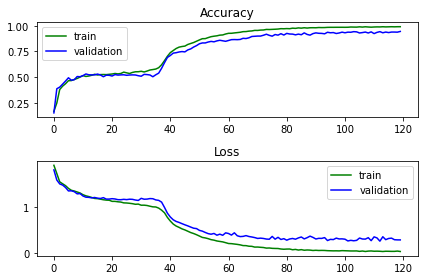

In [33]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [34]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 는 어디 야 ?        : 복도      복도
필웅이 는 어디 야 ?        : 화장실     화장실
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 부엌      부엌
경임이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 복도      복도
경임이 는 어디 야 ?        : 사무실     사무실
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 정원      정원
수종이 는 어디 야 ?        : 사무실     사무실
필웅이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
은경이 는 어디 야 ?        : 부엌      부엌
은경이 는 어디 야 ?        : 정원      정원
은경이 는 어디 야 ?        : 부엌      부엌
수종이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 부엌      부엌
필웅이 는 어디 야 ?        : 복도      복도
은경이 는 어디 야 ?        : 사무실     사무실
은경이 는 어디 야 ?        : 사무실     사무실
경임이 는 어디 야 ?        : 복도      복도
수종이 는 어디 야 ?        : 침실      침실
경임이 는 어디 야 ?        : 침실      침실
필웅이 는 어디 야 ?        : 침실      침실
수종이 는 어디 야 ?        : 부엌      부엌


-----

## 6. postprocessor로 불용어제거

In [32]:
print(word2idx)

{'는': 1, '.': 2, '로': 3, '했습니다': 4, '으로': 5, '경임이': 6, '은경이': 7, '수종이': 8, '필웅이': 9, '이동': 10, '가버렸습니다': 11, '뛰어갔습니다': 12, '복귀': 13, '화장실': 14, '정원': 15, '복도': 16, '갔습니다': 17, '사무실': 18, '부엌': 19, '침실': 20, '어디': 21, '야': 22, '?': 23}


In [33]:
from ckonlpy.tag import Postprocessor

stopwords = {'는',  '로', '으로', '야'}
postprocessor = Postprocessor(
    base_tagger = twitter,
    stopwords = stopwords)

def tokenize2(sent):
    sent_list = []
    sent = postprocessor.pos(sent)
    for a in range(len(sent)):
        sent_1 = sent[a][0]
        sent_list.append(sent_1)
    return sent_list

In [34]:
from ckonlpy.tag import Twitter
twitter = Twitter()
twitter.add_dictionary('수종이', 'Noun')
twitter.add_dictionary('경임이', 'Noun')
twitter.add_dictionary('은경이', 'Noun')
twitter.add_dictionary('필웅이', 'Noun')

counter2 = FreqDist()
sent = '은경이는 어디야?'
test2 = twitter.morphs(sent)
print(test2)
for word in test2:
    counter2[word] +=1

word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter2.most_common())}
print(word2idx)

['은경이', '는', '어디', '야', '?']
{'은경이': 1, '는': 2, '어디': 3, '야': 4, '?': 5}


/home/aiffel0038/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [35]:
sents = ['은경이는 어디야?', '철수는 집에 있어?']
test_len = []
test_list = []
counter = FreqDist()
for sent in sents:
    test = postprocessor.pos(sent)
    test_len.append(len(test))
    for a in range(len(test)):
        test_1 = test[a][0]
        test_list.append(test_1)
    for word in test_list:
        counter[word] +=1
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
print(test_len)

[3, 5]


In [36]:
def preprocess_data(train_data, test_data):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    story_list = []
    question_list = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in stories:
            first_stories = postprocessor.pos(flatten(story))
            story_len.append(len(first_stories))
            for a in range(len(first_stories)):
                stories_1 = first_stories[a][0]
                story_list.append(stories_1)
        for word in story_list: # 단어 집합에 단어 추가
            counter[word] += 1
        for question in questions:
            first_question = postprocessor.pos(flatten(question))
            question_len.append(len(first_question))
            for a in range(len(first_question)):
                question_1 = first_question[a][0]
                question_list.append(question_1)
        for word in question_list:
             counter[word] += 1
        for answer in answers:
            answer = tokenize2(answer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [37]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, test_data)

In [38]:
vocab_size = len(word2idx) + 1
print(vocab_size)

20


In [39]:
print(question_max_len)

3


In [40]:
print(story_max_len)

50


In [41]:
print(word2idx)

{'.': 1, '했습니다': 2, '경임이': 3, '은경이': 4, '수종이': 5, '필웅이': 6, '이동': 7, '뛰어갔습니다': 8, '가버렸습니다': 9, '복귀': 10, '갔습니다': 11, '화장실': 12, '복도': 13, '정원': 14, '사무실': 15, '부엌': 16, '침실': 17, '어디': 18, '?': 19}


## 7. 토큰화하기

In [42]:
def vectorize(data, word2idx, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in zip(stories, questions, answers):
        xs = [word2idx[w] for w in tokenize2(flatten(story))]
        xq = [word2idx[w] for w in tokenize2(question)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [43]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, word2idx, story_max_len, question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, word2idx, story_max_len, question_max_len)

In [44]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 50) (10000, 3) (10000, 20) (1000, 50) (1000, 3) (1000, 20)


In [72]:
# 에포크 횟수
train_epochs = 120
# 배치 크기
batch_size = 32
# 임베딩 크기
embed_size = 50
# LSTM의 크기
lstm_size = 64
# 과적합 방지 기법인 드롭아웃 적용 비율
dropout_rate = 0.30

In [73]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : Tensor("input_7:0", shape=(None, 50), dtype=float32)
Question: Tensor("input_8:0", shape=(None, 3), dtype=float32)


In [74]:
# 스토리를 위한 첫번째 임베딩. 그림에서의 Embedding A
input_encoder_m = Sequential()
input_encoder_m.add(Embedding(input_dim=vocab_size,
                              output_dim=embed_size))
input_encoder_m.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, embed_size) / 샘플의 수, 문장의 최대 길이, 임베딩 벡터의 차원
 
# 스토리를 위한 두번째 임베딩. 그림에서의 Embedding C
# 임베딩 벡터의 차원을 question_max_len(질문의 최대 길이)로 한다.
input_encoder_c = Sequential()
input_encoder_c.add(Embedding(input_dim=vocab_size,
                              output_dim=question_max_len))
input_encoder_c.add(Dropout(dropout_rate))
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이(임베딩 벡터의 차원)

In [75]:
# 질문을 위한 임베딩. 그림에서의 Embedding B
question_encoder = Sequential()
question_encoder.add(Embedding(input_dim=vocab_size,
                               output_dim=embed_size,
                               input_length=question_max_len))
question_encoder.add(Dropout(dropout_rate))
# 결과 : (samples, question_max_len, embed_size) / 샘플의 수, 질문의 최대 길이, 임베딩 벡터의 차원

In [76]:
# 실질적인 임베딩 과정
input_encoded_m = input_encoder_m(input_sequence)
input_encoded_c = input_encoder_c(input_sequence)
question_encoded = question_encoder(question)

print('Input encoded m', input_encoded_m)
print('Input encoded c', input_encoded_c)
print('Question encoded', question_encoded)

Input encoded m Tensor("sequential_9/Identity:0", shape=(None, 50, 50), dtype=float32)
Input encoded c Tensor("sequential_10/Identity:0", shape=(None, 50, 3), dtype=float32)
Question encoded Tensor("sequential_11/Identity:0", shape=(None, 3, 50), dtype=float32)


In [77]:
# 스토리 단어들과 질문 단어들 간의 유사도를 구하는 과정
# 유사도는 내적을 사용한다.
match = dot([input_encoded_m, question_encoded], axes=-1, normalize=False)
match = Activation('softmax')(match)
print('Match shape', match)
# 결과 : (samples, story_max_len, question_max_len) / 샘플의 수, 문장의 최대 길이, 질문의 최대 길이

Match shape Tensor("activation_6/Identity:0", shape=(None, 50, 3), dtype=float32)


In [78]:
# 매칭 유사도 행렬과 질문에 대한 임베딩을 더한다.
response = add([match, input_encoded_c])  # (samples, story_maxlen, question_max_len)
response = Permute((2, 1))(response)  # (samples, question_max_len, story_maxlen)
print('Response shape', response)

Response shape Tensor("permute_3/Identity:0", shape=(None, 3, 50), dtype=float32)


In [79]:
# concatenate the response vector with the question vector sequence
answer = concatenate([response, question_encoded])
print('Answer shape', answer)
 
answer = LSTM(lstm_size)(answer)  # Generate tensors of shape 32
answer = Dropout(dropout_rate)(answer)
answer = Dense(vocab_size)(answer)  # (samples, vocab_size)
# we output a probability distribution over the vocabulary
answer = Activation('softmax')(answer)

Answer shape Tensor("concatenate_3/Identity:0", shape=(None, 3, 100), dtype=float32)


In [80]:
model = Model([input_sequence, question], answer)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

## 8. 모델 훈련시키기

In [81]:
# 테스트 데이터를 검증 데이터로 사용하면서 모델 훈련 시작
history = model.fit([Xstrain, Xqtrain],
         Ytrain, batch_size, train_epochs,
         validation_data=([Xstest, Xqtest], Ytest))
 
# 훈련 후에는 모델 저장
model_path = os.getenv('HOME')+'/aiffel/babi_memory_net/data/stopwords_model.h5'
model.save(model_path)

Epoch 1/120
313/313 [==============================] - 1s 4ms/step - loss: 1.8931 - acc: 0.1670 - val_loss: 1.7924 - val_acc: 0.2430
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7702 - acc: 0.2058 - val_loss: 1.6680 - val_acc: 0.2750
Epoch 3/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6660 - acc: 0.2752 - val_loss: 1.6090 - val_acc: 0.3280
Epoch 4/120
313/313 [==============================] - 1s 3ms/step - loss: 1.6061 - acc: 0.3257 - val_loss: 1.5162 - val_acc: 0.3680
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5385 - acc: 0.3702 - val_loss: 1.4812 - val_acc: 0.4100
Epoch 6/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5047 - acc: 0.4062 - val_loss: 1.4674 - val_acc: 0.3960
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4701 - acc: 0.4217 - val_loss: 1.4124 - val_acc: 0.4320
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

## 9. 모델 평가하기

In [82]:
print("\n 테스트 정확도: %.4f" % (model.evaluate([Xstest, Xqtest], Ytest)[1]))

32/32 [==============================] - 0s 2ms/step - loss: 0.1406 - acc: 0.9500

 테스트 정확도: 0.9500


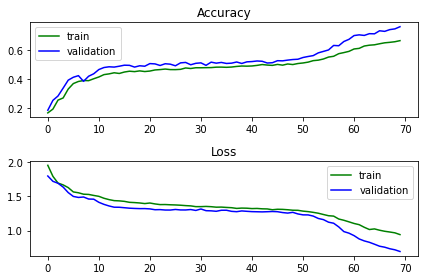

In [70]:
# plot accuracy and loss plot
plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = model.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [71]:
NUM_DISPLAY = 30

print("{:18}|{:5}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:7} {}".format(question, label, prediction))

질문                |실제값  |예측값
---------------------------------------
은경이 어디 ?            : 복도      복도
필웅이 어디 ?            : 화장실     침실
경임이 어디 ?            : 부엌      부엌
경임이 어디 ?            : 복도      복도
경임이 어디 ?            : 부엌      부엌
경임이 어디 ?            : 복도      복도
경임이 어디 ?            : 정원      정원
수종이 어디 ?            : 복도      복도
경임이 어디 ?            : 사무실     사무실
수종이 어디 ?            : 사무실     사무실
필웅이 어디 ?            : 부엌      부엌
필웅이 어디 ?            : 정원      정원
수종이 어디 ?            : 사무실     화장실
필웅이 어디 ?            : 침실      침실
필웅이 어디 ?            : 침실      침실
은경이 어디 ?            : 부엌      부엌
은경이 어디 ?            : 정원      정원
은경이 어디 ?            : 부엌      부엌
수종이 어디 ?            : 사무실     부엌
은경이 어디 ?            : 부엌      복도
필웅이 어디 ?            : 복도      복도
은경이 어디 ?            : 사무실     사무실
은경이 어디 ?            : 사무실     사무실
경임이 어디 ?            : 복도      침실
수종이 어디 ?            : 침실      정원
경임이 어디 ?            : 침실      침실
필웅이 어디 ?            : 침실      침실
수종이 어디 ?            : 부엌      부엌
수종

## 10. 총평

일단 customized konlpy를 처음 써봤는데 생각보다 유용해서 좋았다.    
postprocessor같은 경우 morphs 메서드가 없어서 list로 만들어주는 방식을 택했는데 시행착오를 계속 겪었다.    
성능은 확실히 불용어를 제거해준 것이 제거하지 않은 것보다 성능이 훨씬 좋다는 것을 알 수 있었다.    